# Q4 Linear Quadratic Control

## Problem data and plotting functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 5]

A = np.array([[.99, .03, -.02, -.32], [.01, .47, 4.7, 0], [.02, -.06, .4, 0], [.01, -.04, .72, .99]])
B = np.array([[.01, .99], [-3.44, 1.66], [-.83, .44], [-.47, .25]])

n, m = B.shape
C = np.eye(n)

x_init = np.array([0, 0, 0, 1])
x_des  = np.zeros(n)
T   = 100

def plot_trajectories(x):

    plt.plot(x,)
    plt.title('optimal state trajectory')
    plt.xlabel('t')
    plt.ylabel('state components')
    
def plot_inputs(u):
    plt.plot(u)
    plt.title('optimal input trajectory')
    plt.xlabel('t')
    plt.ylabel('inputs components')
    
def make_plots(x,u):
    
    plt.subplot(1,2,1)
    plot_trajectories(x.value.transpose())
    plt.subplot(1,2,2)
    plot_inputs(u.value.transpose())

## Linear quadratic control

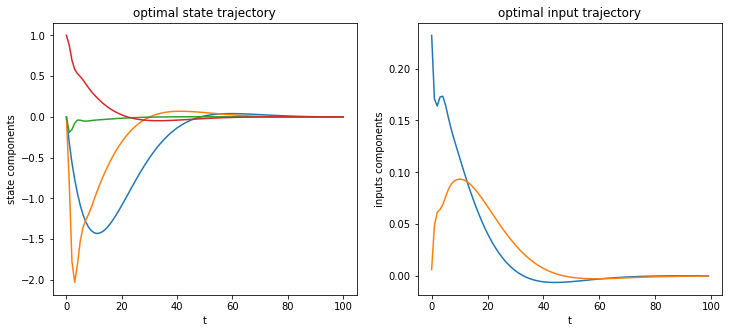

In [2]:
# Form and solve control problem.
import cvxpy as cp

x = cp.Variable((n, T+1))
u = cp.Variable((m, T))

#initialize cost and constraints
cost   = 0     #no cost function yet
constr = []    #no constraints yet

for t in range(T):
    
    #quadratic cost function
    cost   += cp.sum_squares(x[:,t+1]) + 100*cp.sum_squares(u[:,t])
    
    #equality constraints from dynamics
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t]]
    
# initial/terminal conditions
constr += [x[:,T] == 0, x[:,0] == x_init]

#optimize
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(solver=cp.ECOS)

#plot
make_plots(x,u)

## 1-norm control

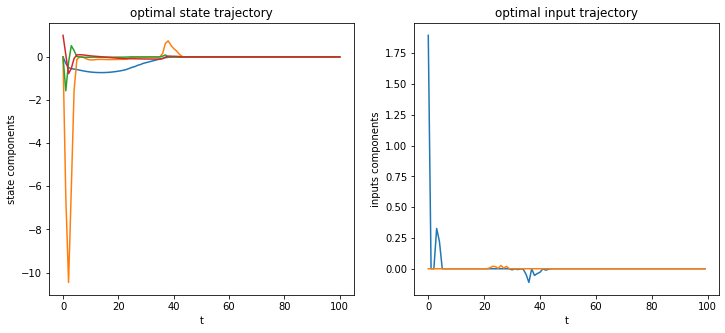

In [3]:
# Form and solve control problem.
import cvxpy as cp

x = cp.Variable((n, T+1))
u = cp.Variable((m, T))

#initialize cost and constraints
cost   = 0     #no cost function yet
constr = []    #no constraints yet

for t in range(T):
    
    #quadratic cost function
    cost   += cp.norm(x[:,t+1],1) + 100*cp.norm(u[:,t],1)
    
    #equality constraints from dynamics
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t]]
    
# initial/terminal conditions
constr += [x[:,T] == 0, x[:,0] == x_init]

#optimize
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(solver=cp.ECOS)

#plot
make_plots(x,u)

## 1-norm control with input and rate constraints and soft penalties.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.491e+02  +5e+04  4e-01  2e-02  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  +4.284e+01  +2.428e+00  +1e+04  1e-01  5e-03  5e-01  6e+00  0.7327  2e-02   1  1  1 |  0  0
 2  +5.713e+01  +4.144e+01  +5e+03  5e-02  2e-03  6e-01  2e+00  0.6744  1e-01   1  1  1 |  0  0
 3  +1.623e+02  +1.583e+02  +1e+03  1e-02  4e-04  2e-01  6e-01  0.7616  3e-02   1  1  1 |  0  0
 4  +1.991e+02  +1.965e+02  +8e+02  8e-03  3e-04  2e-01  4e-01  0.4446  2e-01   1  1  1 |  0  0
 5  +2.348e+02  +2.334e+02  +4e+02  4e-03  1e-04  1e-01  2e-01  0.5198  9e-02   1  1  1 |  0  0
 6  +2.498e+02  +2.490e+02  +2e+02  2e-03  8e-05  7e-02  1e-01  0.5203  1e-01   1  1  1 |  0  0
 7  +2.674e+02  +2.671e+02  +1e+02  9e-04  3e-05  3e-02  5e-02  0.6503  6e-02   1  1  1 |  0  0
 8  +2.752e+02  +2.751e+02  +4e+01  4e-04  1e-

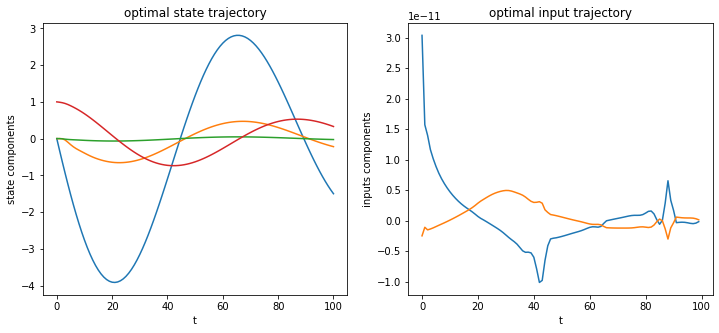

In [10]:
# Form and solve control problem.
import cvxpy as cp

x = cp.Variable((n, T+1))
u = cp.Variable((m, T))
t = cp.Variable(1)

#initialize cost and constraints
cost   = 0     #no cost function yet
constr = []    #no constraints yet

#soft constraint version
cost   = t           #soft constraint violation
constr = [t >= 0]    #non-negative soft penalty

u_init     = np.array([0,0])
u_rate_max = np.array([0.0005,0.0005])   #try 0.0005

for t in range(T):
    
    #quadratic cost function
    cost   += cp.norm(x[:,t+1],1) + 100*cp.norm(u[:,t],1)
    
    #equality constraints from dynamics
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t]]
    
    #input constraints
    constr += [cp.abs(u[0,t]) <= 0.50]
    
    #input rate
    if(t > 0):
        constr += [cp.abs(u[:,t] - u[:,t-1]) <= u_rate_max]
    else:
        constr += [cp.abs(u[:,t] - u_init) <= u_rate_max]   
    

# initial/terminal conditions
#constr += [x[:,T] == 0, x[:,0] == x_init]

# initial/terminal conditions (soft version)
constr += [cp.norm(x[:,T],1) <= t, x[:,0] == x_init]   #soft penalties
cost += t*100

#optimize
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(verbose=True,solver=cp.ECOS)

#plot
make_plots(x,u)